In [1]:
import wandb
import equinox as eqx
import os 

# Foundational SSM imports
from omegaconf import OmegaConf
import tempfile 
from foundational_ssm.models import SSMDownstreamDecoder, SSMFoundationalDecoder
from foundational_ssm.utils import h5_to_dict
from foundational_ssm.transform import smooth_spikes
import jax
import jax.numpy as jnp
import numpy as np
from typing import Any, BinaryIO


%load_ext autoreload
%autoreload 2

def default_deserialise_filter_spec(f: BinaryIO, x: Any) -> Any:
    """Default filter specification for deserialising saved data.

    **Arguments**

    -   `f`: file-like object
    -   `x`: The leaf for which the data needs to be loaded.

    **Returns**

    The new value for datatype `x`.

    !!! info

        This function can be extended to customise the deserialisation behaviour for
        leaves.

    !!! example

        Skipping loading of jax.Array.

        ```python
        import jax.numpy as jnp
        import equinox as eqx

        tree = (jnp.array([4,5,6]), [1,2,3])
        new_filter_spec = lambda f,x: (
            x if isinstance(x, jax.Array) else eqx.default_deserialise_filter_spec(f, x)
        )
        new_tree = eqx.tree_deserialise_leaves("some_filename.eqx", tree, filter_spec=new_filter_spec)
        ```
    """  # noqa: E501
    try:
        if isinstance(x, (jax.Array, jax.ShapeDtypeStruct)):
            return jnp.load(f)
        elif isinstance(x, np.ndarray):
            # Important to use `np` here to avoid promoting NumPy arrays to JAX.
            return np.load(f)
        elif eqx.is_array_like(x):
            # np.generic gets deserialised directly as an array, so convert back to a scalar
            # type here.
            # See also https://github.com/google/jax/issues/17858
            out = np.load(f)
            if isinstance(x, jax.dtypes.bfloat16):
                out = out.view(jax.dtypes.bfloat16)
            if np.size(out) == 1:
                return type(x)(out.item())
        else:
            return x
    except:
        print("Failed to load data for leaf with shape/ value:", x.shape if hasattr(x, 'shape') else x)
        return x 

def load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMDownstreamDecoder, model_cfg=None):
    """Load model, optimizer state, epoch, and step from a checkpoint file."""
    api = wandb.Api()
    try:
        artifact = api.artifact(artifact_full_name, type="checkpoint")
    except Exception as e:
        raise FileNotFoundError(f"Could not find checkpoint artifact: {artifact_full_name}")
    
    if model_cfg is None:
        run = artifact.logged_by()
        run_cfg = OmegaConf.create(run.config)
        print(run_cfg)
        model_cfg = OmegaConf.create(run_cfg.model)
    
    model_template, state_template = eqx.nn.make_with_state(model_cls)(
        **model_cfg
    )
    
    with tempfile.TemporaryDirectory() as temp_dir:
        artifact.download(temp_dir)
        model = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "model.ckpt"), model_template, default_deserialise_filter_spec)
        state = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "state.ckpt"), state_template, default_deserialise_filter_spec)

    meta = artifact.metadata
    return model, state, meta

# Loading the Downstream Model

In [2]:
layer = "2"
pretrain_mode = "scratch"
train_mode = "all"
alias = "best" # can be latest/best/ epoch_{any value in range(0,1000,100)}
# epoch 0 now stores a fresh model.
artifact_full_name = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:{alias}"
model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name)

{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 32, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.03, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1500, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


# Loading the Foundational Model

In [10]:
model = "l2"
dataset = "similar_task"
alias = "best"

# Bit of a hack to manually feed in model params for now. Future renditions wont need this. 
model_cfg = {
    "ssm_io_dim": 256,
    "ssm_dim": 256,
    "ssm_init_diag_blocks": 4,
    "ssm_num_layers": 2,
    "output_dim": 2,
    "rng_seed": 42,
    "dt_min": 0.001,
    "dt_max": 0.01,
    "dropout_p": 0.03,
    "ssm_dropout_p": 0.03
}
artifact_full_name = f"melinajingting-ucl/foundational_ssm_pretrain/{model}_{dataset}_checkpoint:{alias}"
model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMFoundationalDecoder, model_cfg=model_cfg)

wandb:   3 of 3 files downloaded.  


# Calling with activations (Downstream)

In [3]:
# Download mc_rtt_trialized from https://huggingface.co/datasets/MelinaLaimon/nlb_processed/tree/main
# Edit dataset_dir to your directory
dataset_dir = "../../data/foundational_ssm/processed/nlb" 
dataset_path = os.path.join(dataset_dir, "mc_rtt_trialized.h5")
data = h5_to_dict(dataset_path)
data["neural_input"] = smooth_spikes(data["neural_input"], kern_sd_ms=20, bin_size_ms=5, time_axis=1)
input = data["neural_input"]
target_vel = data["behavior_input"]

# Specify the layers you want to generate the activations of. 
# ["post_encoder", "ssm_pre_activation", "ssm_post_activation"]
layer_keys = ["ssm_pre_activation"] 
inf_model = eqx.nn.inference_mode(model) # Switches off dropout
pred_vel, _, activations = jax.vmap(inf_model.call_with_activations, axis_name="batch", in_axes=(0, None, None))(input, state, layer_keys)

# Example: Plotting Output

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
trial_info = pd.read_csv(os.path.join(dataset_dir, "mc_rtt_trialized.csv"))
dt = 0.005  # or your actual timestep size
skip_timesteps = 56 

target_vel_sliced = target_vel[:, skip_timesteps:, :]  # Skip the first 56 timesteps
target_pos = np.cumsum(target_vel_sliced * dt, axis=1)
pred_vel_sliced = pred_vel[:, skip_timesteps:, :]  # Skip the first 56 timesteps
pred_pos = np.cumsum(pred_vel_sliced * dt, axis=1)
n_samples = pred_vel_sliced.shape[0]
n_train_samples = int(0.7 * n_samples)

bin_size = 10
bins = np.arange(0, 361, bin_size)
labels = [f"{i}-{i+bin_size}" for i in bins[:-1]]
trial_info["angle_bin_label"] = pd.cut(trial_info["reach_angle"] % 360, bins=bins, labels=labels, right=False)
trial_info["split"] = ["train"] * n_train_samples + ["val"] * (n_samples - n_train_samples)
trial_info.to_csv(os.path.join(dataset_dir, "mc_rtt_trialized.csv"), index=False)

NameError: name 'os' is not defined

In [ ]:
rows = []
for split in ['train', 'val']:
    for angle_bin_label in labels:
        filter_idx = trial_info[(trial_info['angle_bin_label'] == angle_bin_label) & (trial_info["split"] == split)].index.values
        if len(filter_idx) == 0:
            continue
        # Use correct arrays for val/train
        if split == 'val':
            # For val, use velocity for r2 metrics (if that's your intent)
            try:
                r2 = r2_score(target_vel_sliced[filter_idx].reshape(-1, 2), pred_vel_sliced[filter_idx].reshape(-1, 2))
                r2_varW = r2_score(target_vel_sliced[filter_idx].reshape(-1, 2), pred_vel_sliced[filter_idx].reshape(-1, 2), multioutput='variance_weighted')
                r2_x = r2_score(np.atleast_2d(target_vel_sliced[filter_idx].reshape(-1, 2))[:, 0], np.atleast_2d(pred_vel_sliced[filter_idx].reshape(-1, 2))[:, 0])
                r2_y = r2_score(np.atleast_2d(target_vel_sliced[filter_idx].reshape(-1, 2))[:, 1], np.atleast_2d(pred_vel_sliced[filter_idx].reshape(-1, 2))[:, 1])
            except Exception:
                r2 = r2_varW = r2_x = r2_y = np.nan
        else:
            r2 = r2_score(target_pos[filter_idx].reshape(-1, 2), pred_pos[filter_idx].reshape(-1, 2))
            r2_varW = r2_score(target_pos[filter_idx].reshape(-1, 2), pred_pos[filter_idx].reshape(-1, 2), multioutput='variance_weighted')
            r2_x = r2_score(np.atleast_2d(target_pos[filter_idx])[:, 0], np.atleast_2d(pred_pos[filter_idx])[:, 0])
            r2_y = r2_score(np.atleast_2d(target_pos[filter_idx])[:, 1], np.atleast_2d(pred_pos[filter_idx])[:, 1])

        rows.append({
            'split': split,
            'angle_bin_label': angle_bin_label,
            'target_pos_mean': np.mean(target_pos[filter_idx], axis=0),
            'target_pos_std': np.std(target_pos[filter_idx], axis=0),
            'pred_pos_mean': np.mean(pred_pos[filter_idx], axis=0),
            'pred_pos_std': np.std(pred_pos[filter_idx], axis=0),
            'error': np.std(target_pos[filter_idx] - pred_pos[filter_idx], axis=0),
            'r2': r2,
            'r2_varW': r2_varW,
            'r2_x': r2_x,
            'r2_y': r2_y
        })

results_df = pd.DataFrame(rows)

In [16]:
from sklearn.metrics import r2_score
results = {
    'train': {
        'target_pos_mean': {},
        'target_pos_std': {},
        'pred_pos_mean': {},
        'pred_pos_std': {},
        'error': {},
        'r2': {},
        'r2_varW': {},
        'r2_x': {},
        'r2_y': {}
    },
    'val': {
        'target_pos_mean': {},
        'target_pos_std': {},
        'pred_pos_mean': {},
        'pred_pos_std': {},
        'error': {},
        'r2': {},
        'r2_varW': {},
        'r2_x': {},
        'r2_y': {},
    }
}

for angle_bin_label in trial_info['angle_bin_label'].unique():
    filter = trial_info[(trial_info['angle_bin_label'] == angle_bin_label) & (trial_info["split"].isin(["train"]))].index.values
    results['train']['target_pos_mean'][angle_bin_label] = np.mean(target_pos[filter], axis=0)
    results['train']['target_pos_std'][angle_bin_label] = np.std(target_pos[filter], axis=0)
    results['train']['pred_pos_mean'][angle_bin_label] = np.mean(pred_pos[filter], axis=0)
    results['train']['pred_pos_std'][angle_bin_label] = np.std(pred_pos[filter], axis=0)
    results['train']['error'][angle_bin_label] = np.std(target_pos[filter] - pred_pos[filter], axis=0)
    results['train']['r2'][angle_bin_label] = r2_score(target_pos[filter].reshape(-1, 2), pred_pos[filter].reshape(-1, 2))
    results['train']['r2_varW'][angle_bin_label] = r2_score(target_pos[filter].reshape(-1, 2), pred_pos[filter].reshape(-1, 2), multioutput='variance_weighted')
    results['train']['r2_x'][angle_bin_label] = r2_score(np.atleast_2d(target_pos[filter])[:, 0], np.atleast_2d(pred_pos[filter])[:, 0])
    results['train']['r2_y'][angle_bin_label] = r2_score(np.atleast_2d(target_pos[filter])[:, 1], np.atleast_2d(pred_pos[filter])[:, 1])

    filter = trial_info[(trial_info['angle_bin_label'] == angle_bin_label) & (trial_info["split"].isin(["val"]))].index.values
    results['val']['target_pos_mean'][angle_bin_label] = np.mean(target_pos[filter], axis=0)
    results['val']['target_pos_std'][angle_bin_label] = np.std(target_pos[filter], axis=0)
    results['val']['pred_pos_mean'][angle_bin_label] = np.mean(pred_pos[filter], axis=0)
    results['val']['pred_pos_std'][angle_bin_label] = np.std(pred_pos[filter], axis=0)
    results['val']['error'][angle_bin_label] = np.std(target_pos[filter] - pred_pos[filter], axis=0)
    try:
        results['val']['r2'][angle_bin_label] = r2_score(target_vel_sliced[filter].reshape(-1, 2), pred_vel_sliced[filter].reshape(-1, 2))
        results['val']['r2_varW'][angle_bin_label] = r2_score(target_vel_sliced[filter].reshape(-1, 2), pred_vel_sliced[filter].reshape(-1, 2), multioutput='variance_weighted')
        results['val']['r2_x'][angle_bin_label] = r2_score(np.atleast_2d(target_vel_sliced[filter].reshape(-1, 2))[:, 0], np.atleast_2d(pred_vel_sliced[filter].reshape(-1, 2))[:, 0])
        results['val']['r2_y'][angle_bin_label] = r2_score(np.atleast_2d(target_vel_sliced[filter].reshape(-1, 2))[:, 1], np.atleast_2d(pred_vel_sliced[filter].reshape(-1, 2))[:, 1])
    except:
        pass

/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/cs/student/projects1/ml/2024/mlaimon/anaconda3/en

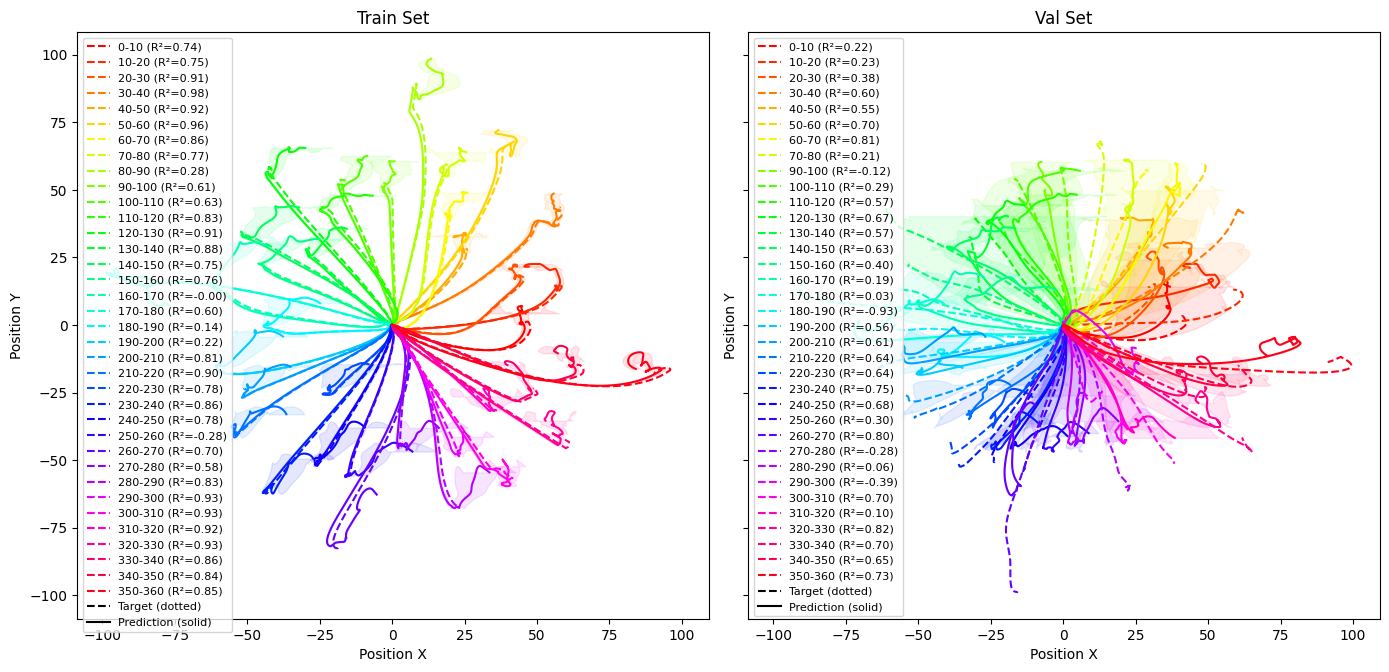

In [17]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)
splits = ['train', 'val']
colors = plt.cm.hsv(np.linspace(0, 1, len(labels)))

for i, split in enumerate(splits):
    ax = axs[i]
    for j, angle_bin_label in enumerate(labels):
        target_mean = results[split]['target_pos_mean'][angle_bin_label]
        target_std = results[split]['target_pos_std'][angle_bin_label]
        pred_mean = results[split]['pred_pos_mean'][angle_bin_label]
        error = results[split]['error'][angle_bin_label]

        # Only add label for angle bins on target line
        if angle_bin_label in results[split]['r2']:
            r2_val = results[split]['r2'][angle_bin_label]
            ax.plot(target_mean[:, 0], target_mean[:, 1], linestyle='--', color=colors[j], label=f'{angle_bin_label} (R²={r2_val:.2f})')
            ax.plot(pred_mean[:, 0], pred_mean[:, 1], linestyle='-', color=colors[j])

            ax.fill_betweenx(
                pred_mean[:, 1],
                pred_mean[:, 0] - error[:, 0],
                pred_mean[:, 0] + error[:, 0],
                color=colors[j], alpha=0.1
            )

    ax.set_title(f"{split.capitalize()} Set")
    ax.set_xlabel("Position X")
    ax.set_ylabel("Position Y")

    # Custom legend for line styles
    handles, labels_ = ax.get_legend_handles_labels()
    custom_lines = [
        Line2D([0], [0], color='black', linestyle='--', label='Target (dotted)'),
        Line2D([0], [0], color='black', linestyle='-', label='Prediction (solid)')
    ]
    ax.legend(handles=handles + custom_lines, fontsize=8, loc='best')

plt.tight_layout()
plt.show()

In [19]:
trial_info['pos'] = trial_info[['start_pos', 'target_pos']].apply(tuple, axis=1)
trial_agg_angle_summary = (
    trial_info
    .groupby(['split', 'angle_bin_label'])
    .agg(
        count=('trial_id', 'count'),
        unique_pos=('pos', 'nunique'),
        total_duration=('duration', 'sum')
    )
    .reset_index()
)
trial_agg_angle_summary['r2'] = trial_agg_angle_summary.apply(lambda row: results[row['split']]['r2'].get(row['angle_bin_label'], np.nan), axis=1)
trial_agg_angle_summary['r2_varW'] = trial_agg_angle_summary.apply(lambda row: results[row['split']]['r2_varW'].get(row['angle_bin_label'], np.nan), axis=1)
trial_agg_angle_summary['r2_x'] = trial_agg_angle_summary.apply(lambda row: results[row['split']]['r2_x'].get(row['angle_bin_label'], np.nan), axis=1)
trial_agg_angle_summary['r2_y'] = trial_agg_angle_summary.apply(lambda row: results[row['split']]['r2_y'].get(row['angle_bin_label'], np.nan), axis=1)
trial_agg_angle_summary[trial_agg_angle_summary['split']=='val']

/tmp/ipykernel_80652/2767090783.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['split', 'angle_bin_label'])


,split,angle_bin_label,count,unique_pos,total_duration,r2,r2_varW,r2_x,r2_y
36,val,0-10,15,15,16.020,0.221033,0.613299,0.733455,-0.291389
37,val,10-20,2,2,2.192,0.225367,0.863563,0.934679,-0.483945
38,val,20-30,6,5,6.924,0.382541,0.454231,0.564927,0.200156
39,val,30-40,8,7,9.832,0.598863,0.630493,0.689288,0.508438
40,val,40-50,6,6,6.636,0.545868,0.547546,0.494539,0.597196
41,val,50-60,3,3,3.408,0.704912,0.712650,0.659729,0.750094
42,val,60-70,2,2,2.328,0.810890,0.861891,0.729730,0.892050
43,val,70-80,7,7,10.344,0.214262,0.634001,-0.322381,0.750905
44,val,80-90,0,0,0.000,NaN,NaN,NaN,NaN
45,val,90-100,4,4,5.712,-0.122821,0.781065,-1.115412,0.869770
